In [1]:
import random
from math import sin, cos, pi, exp, e, sqrt
from operator import mul
from functools import reduce

from deap import base, creator, tools, algorithms, benchmarks 

import numpy as np
import autograd.numpy as anp
import pandas as pd

import pymop
from deap.benchmarks.tools import diversity, convergence, hypervolume

import csv
import time, array

import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D

from math import factorial

In [2]:
def uniform(low, up, size=None):
    try:
        return [random.uniform(a, b) for a, b in zip(low, up)]
    except TypeError:
        return [random.uniform(a, b) for a, b in zip([low] * size, [up] * size)]

In [22]:
def measure_time(x):
    execution_time = time.time() - start_time 
#     print(execution_time)
    return execution_time

In [4]:
def nsga_ii(toolbox, seed, stats=None, verbose=False):
    pop = toolbox.population(n=toolbox.pop_size)
    pop = toolbox.select(pop, len(pop))
    random.seed(seed)
    return algorithms.eaMuPlusLambda(pop, 
                                     toolbox, 
                                     mu=toolbox.pop_size, 
                                     lambda_=toolbox.pop_size, 
                                     cxpb=toolbox.cross_prob,
                                     mutpb=toolbox.mut_prob,
                                     ngen=toolbox.max_gen,
                                     stats=stats, 
                                     verbose=verbose)

In [5]:
def nsga_iii(toolbox,stats,logbook,NGEN,MU,CXPB,MUTPB,verbose=False):
    pop = toolbox.population(n=MU)
    invalid_ind = [ind for ind in pop if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
#   fitnesses = toolbox.map(toolbox.evaluate, pop)        
#     for ind, fit in zip(pop, fitnesses):
#         ind.fitness.values = fit
    
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    pop = toolbox.select(pop, len(pop))
    
    # Begin the generational process
    for gen in range(1, NGEN):
        offspring = algorithms.varAnd(pop, toolbox, CXPB, MUTPB)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        
        record = stats.compile(pop) if stats is not None else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        
        if verbose:
            print(logbook.stream)
        
        # Select the next generation population
        pop = toolbox.select(pop + offspring, MU)
    
    return pop, logbook

In [6]:
def dtlz1(individual, obj=3):
    g = 100 * (len(individual[obj - 1:]) + sum((xi - 0.5)**2 - cos(20 * pi * (xi - 0.5)) for xi in individual[obj - 1:]))
    f = [0.5 * reduce(mul, individual[:obj - 1], 1) * (1 + g)]
    f.extend(0.5 * reduce(mul, individual[:m], 1) * (1 - individual[m]) * (1 + g) for m in reversed(range(obj - 1)))
    
    return f

In [7]:
def dtlz2(individual, obj=4):
    xc = individual[:obj - 1]
    xm = individual[obj - 1:]
    g = sum((xi - 0.5)**2 for xi in xm)
    f = [(1.0 + g) * reduce(mul, (cos(0.5 * xi * pi) for xi in xc), 1.0)]
    f.extend((1.0 + g) * reduce(mul, (cos(0.5 * xi * pi) for xi in xc[:m]), 1) * sin(0.5 * xc[m] * pi) for m in range(obj - 2, -1, -1))

    return f

In [8]:
def dtlz3(individual, obj=6):
    xc = individual[:obj - 1]
    xm = individual[obj - 1:]
    g = 100 * (len(xm) + sum((xi - 0.5)**2 - cos(20 * pi * (xi - 0.5)) for xi in xm))
    f = [(1.0 + g) * reduce(mul, (cos(0.5 * xi * pi) for xi in xc), 1.0)]
    f.extend((1.0 + g) * reduce(mul, (cos(0.5 * xi * pi) for xi in xc[:m]), 1) * sin(0.5 * xc[m] * pi) for m in range(obj - 2, -1, -1))
    
    return f

In [9]:
def dtlz7(ind, n_objs=3):
    gval = 1 + 9.0 / len(ind[n_objs - 1:]) * sum([a for a in ind[n_objs - 1:]])
    fit = [x for x in ind[:n_objs - 1]]
    fit.append((1 + gval) * (n_objs - sum([a / (1.0 + gval) * (1 + sin(3 * pi * a)) for a in ind[:n_objs - 1]])))
    
    return fit

In [58]:
NOBJ = 3
NDIM = 4
BOUND_LOW, BOUND_UP = 0.0, 1.0
NGEN = 500
CXPB = 0.8
MUTPB = 0.2

P = 12
H = factorial(NOBJ + P - 1) / (factorial(P) * factorial(NOBJ - 1))

MU = int(H + (4 - H % 4))

creator.create("FitnessMin", base.Fitness, weights=(-1.0,) * NOBJ) # for minimization
creator.create("Individual", list, fitness=creator.FitnessMin) 

toolbox = base.Toolbox()

toolbox.register("evaluate", dtlz1) #Fitness Function

#Chromosome representation Real Valued
toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, NDIM) 
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0)
toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/NDIM)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("select", tools.selNSGA2)

toolbox.pop_size = MU
toolbox.max_gen = NGEN
toolbox.mut_prob = MUTPB
toolbox.cross_prob = CXPB

# Initialize statistics object
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
stats.register("time", measure_time)

logbook = tools.Logbook()
logbook.header = "gen", "evals", "std", "min", "avg", "max", "time"

# stats = tools.Statistics()

C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [59]:
start_time = time.time()
res, logbook = nsga_ii(toolbox=toolbox, seed=1, stats=stats, verbose=True)

fronts = tools.emo.sortLogNondominated(res, len(res))

for i, inds in enumerate(fronts):
    par = [toolbox.evaluate(ind) for ind in inds]
    df = pd.DataFrame(par)

df.to_csv('deap_fitness_nsga2_dtlz1_92_500_3_4.csv', index=False)
df = pd.DataFrame(logbook)
df.to_csv('deap_time_nsga2_dtlz1_92_500_3_4.csv', index=False)

0.010032176971435547
gen	nevals	avg    	std    	min      	max    	time     
0  	92    	39.1158	37.9117	0.0155701	181.312	0.0100322
0.09131765365600586
1  	92    	26.1875	32.4209	0.0155701	170.161	0.0913177
0.15582656860351562
2  	92    	22.248 	32.9053	0.0040877	170.161	0.155827 
0.2171187400817871
3  	92    	17.7866	29.3255	0.000903294	170.161	0.217119 
0.2817697525024414
4  	92    	13.4794	23.803 	0.000543301	169.037	0.28177  
0.35407042503356934
5  	92    	11.1114	21.0574	0.000543301	170.157	0.35407  
0.4087517261505127
6  	92    	8.6106 	20.0087	0.000127949	155.168	0.408752 
0.4688429832458496
7  	92    	8.367  	20.4545	0.000127949	152.108	0.468843 
0.5247077941894531
8  	92    	5.50861	11.6905	0.000127949	74.8488	0.524708 
0.5811200141906738
9  	92    	4.50236	9.49066	0.000127949	74.8488	0.58112  
0.6405956745147705
10 	92    	3.86288	6.95575	0.000105194	50.3219	0.640596 
0.6870274543762207
11 	92    	3.70055	10.5769	6.35272e-05	151.682	0.687027 
0.731928825378418
12 	92    	3.755

6.896783351898193
106	92    	0.333198	0.312706	1.64417e-11	1.07824	6.89678  
6.959907293319702
107	92    	0.335469	0.31066 	1.64417e-11	1.07824	6.95991  
7.024388551712036
108	92    	0.331238	0.312531	1.64417e-11	1.07824	7.02439  
7.087778091430664
109	92    	0.328556	0.305562	1.64417e-11	1.07824	7.08778  
7.14998197555542
110	92    	0.328846	0.304755	1.64417e-11	1.07824	7.14998  
7.216047763824463
111	92    	0.329818	0.306918	1.64417e-11	1.07824	7.21605  
7.2887043952941895
112	92    	0.328673	0.311234	1.64417e-11	1.07824	7.2887   
7.376636981964111
113	92    	0.327152	0.305884	1.64417e-11	1.07824	7.37664  
7.442023992538452
114	92    	0.324717	0.313867	1.64417e-11	1.07813	7.44202  
7.511857509613037
115	92    	0.330829	0.342136	1.64417e-11	2.20579	7.51186  
7.571124315261841
116	92    	0.333544	0.353963	1.64417e-11	2.20579	7.57112  
7.626035690307617
117	92    	0.335655	0.380618	1.64417e-11	2.20579	7.62604  
7.687764644622803
118	92    	0.320557	0.399796	1.64401e-11	2.20579	7.68776  

13.690362453460693
213	92    	0.167074	0.146762	2.1012e-13 	0.509014	13.6904  
13.745705842971802
214	92    	0.167121	0.150278	2.1012e-13 	0.509014	13.7457  
13.836188554763794
215	92    	0.167022	0.149067	2.1012e-13 	0.508482	13.8362  
13.893114566802979
216	92    	0.166992	0.147297	2.1012e-13 	0.508482	13.8931  
13.958214521408081
217	92    	0.166978	0.145969	2.1012e-13 	0.508548	13.9582  
14.0192129611969
218	92    	0.167042	0.146039	2.1012e-13 	0.508548	14.0192  
14.068867444992065
219	92    	0.167027	0.145601	2.1012e-13 	0.508548	14.0689  
14.136893510818481
220	92    	0.166989	0.146613	2.1012e-13 	0.508482	14.1369  
14.179824829101562
221	92    	0.166997	0.145137	1.42481e-13	0.500671	14.1798  
14.234706401824951
222	92    	0.166863	0.144968	1.42481e-13	0.500671	14.2347  
14.289766550064087
223	92    	0.166851	0.147235	7.24023e-14	0.500671	14.2898  
14.342868566513062
224	92    	0.166855	0.146732	7.24023e-14	0.500671	14.3429  
14.404798746109009
225	92    	0.166862	0.145973	7.2402

19.88849925994873
319	92    	0.166671	0.14754 	6.23532e-15	0.500014	19.8885  
19.942521333694458
320	92    	0.166671	0.145433	6.23532e-15	0.50001 	19.9425  
19.992289543151855
321	92    	0.166671	0.141116	6.23532e-15	0.50001 	19.9923  
20.05425190925598
322	92    	0.166671	0.143941	6.23532e-15	0.50001 	20.0543  
20.112743616104126
323	92    	0.166671	0.144887	6.23532e-15	0.500032	20.1127  
20.16423225402832
324	92    	0.166671	0.144999	6.23532e-15	0.500032	20.1642  
20.215394258499146
325	92    	0.166671	0.141311	6.23532e-15	0.500032	20.2154  
20.26470184326172
326	92    	0.166671	0.147727	3.68496e-15	0.500032	20.2647  
20.36170721054077
327	92    	0.166671	0.147629	3.68496e-15	0.500032	20.3617  
20.421598434448242
328	92    	0.166671	0.143356	1.46334e-15	0.500032	20.4216  
20.480643272399902
329	92    	0.166671	0.143033	1.46334e-15	0.500032	20.4806  
20.549724102020264
330	92    	0.166671	0.147309	1.46334e-15	0.500032	20.5497  
20.624911546707153
331	92    	0.166671	0.147858	1.46334e-

26.046730518341064
424	92    	0.166667	0.143605	1.95923e-18	0.5     	26.0467  
26.10474705696106
425	92    	0.166667	0.145113	1.95923e-18	0.5     	26.1047  
26.158000230789185
426	92    	0.166667	0.149365	1.95923e-18	0.5     	26.158   
26.21410298347473
427	92    	0.166667	0.145637	1.95923e-18	0.5     	26.2141  
26.270771503448486
428	92    	0.166667	0.148026	1.95923e-18	0.5     	26.2708  
26.323978662490845
429	92    	0.166667	0.148479	1.95923e-18	0.5     	26.324   
26.38145089149475
430	92    	0.166667	0.146812	3.77278e-19	0.5     	26.3815  
26.430252075195312
431	92    	0.166667	0.143036	3.77278e-19	0.5     	26.4303  
26.481078147888184
432	92    	0.166667	0.147967	3.77278e-19	0.5     	26.4811  
26.533155918121338
433	92    	0.166667	0.144553	3.77278e-19	0.5     	26.5332  
26.59197998046875
434	92    	0.166667	0.143432	3.77278e-19	0.5     	26.592   
26.655961990356445
435	92    	0.166667	0.142973	3.77278e-19	0.5     	26.656   
26.70878314971924
436	92    	0.166667	0.143997	3.77278e-

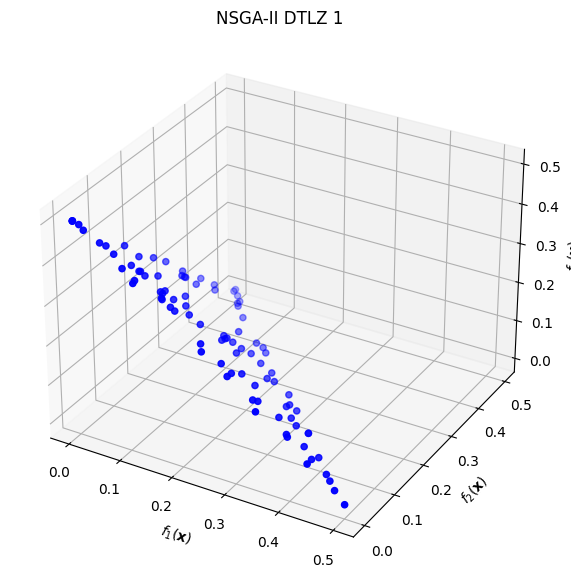

In [61]:
x = [point[0] for point in par]
y = [point[1] for point in par]
z = [point[2] for point in par]

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, color="blue")

plt.title("NSGA-II DTLZ 1")

ax.set_xlabel('$f_1(\mathbf{x})$')
ax.set_ylabel('$f_2(\mathbf{x})$')
ax.set_zlabel('$f_3(\mathbf{x})$')

plt.show()

In [62]:
NOBJ = 3
NDIM = 4
BOUND_LOW, BOUND_UP = 0.0, 1.0
NGEN = 500
CXPB = 0.8
MUTPB = 0.2

P = 12
H = factorial(NOBJ + P - 1) / (factorial(P) * factorial(NOBJ - 1))

MU = int(H + (4 - H % 4))

ref_points = tools.uniform_reference_points(NOBJ, P)

creator.create("FitnessMin", base.Fitness, weights=(-1.0,) * NOBJ) # for minimization
creator.create("Individual", list, fitness=creator.FitnessMin) 

toolbox = base.Toolbox()

toolbox.register("evaluate", dtlz1) #Fitness Function
toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, NDIM)

toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0)
toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/NDIM)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("select", tools.selNSGA3, ref_points=ref_points)

toolbox.pop_size = MU
toolbox.max_gen = NGEN
toolbox.mut_prob = MUTPB
toolbox.cross_prob = CXPB

# Initialize statistics object
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
stats.register("time", measure_time)

logbook = tools.Logbook()
logbook.header = "gen", "evals", "std", "min", "avg", "max", "time"

C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [63]:
start_time = time.time()
res, logbook = nsga_iii(toolbox=toolbox,stats=stats,logbook=logbook,NGEN=NGEN,MU=MU,CXPB=CXPB,MUTPB=MUTPB,verbose=True)

fronts = tools.emo.sortLogNondominated(res, len(res))

for i, inds in enumerate(fronts):
    par = [toolbox.evaluate(ind) for ind in inds]
    df = pd.DataFrame(par)

df.to_csv('deap_fitness_nsga3_dtlz1_92_500_3_4.csv', index=False)

0.02283453941345215
gen	evals	std    	min      	avg    	max    	time     
1  	     	32.8509	0.0477154	33.8277	160.987	0.0228345
0.04281020164489746
2  	     	29.5903	0.0477154	22.6313	162.114	0.0428102
0.05994677543640137
3  	     	21.9025	0.0301235	13.4931	174.416	0.0599468
0.07823014259338379
4  	     	20.478 	0.0013499	10.0067	186.892	0.0782301
0.09824943542480469
5  	     	24.6047	0.000265804	10.1489	197.223	0.0982494
0.11172342300415039
6  	     	19.6568	0.000265804	6.51479	186.929	0.111723 
0.12404584884643555
7  	     	23.3549	0.000265804	7.57164	186.929	0.124046 
0.13738679885864258
8  	     	22.2166	0.000265804	7.5123 	141.072	0.137387 
0.1490774154663086
9  	     	19.1788	5.43498e-05	6.55433	123.214	0.149077 
0.15750503540039062
10 	     	11.2678	5.43498e-05	3.08307	103.79 	0.157505 
0.1721956729888916
11 	     	8.4503 	5.74337e-06	2.25624	99.156 	0.172196 
0.18683767318725586
12 	     	7.39843	7.54944e-07	2.27074	67.7152	0.186838 
0.20928668975830078
13 	     	4.85029	7.5494

1.8262805938720703
109	     	0.152984	8.96256e-08	0.172661	1.00008	1.82628  
1.8470396995544434
110	     	0.161229	8.96256e-08	0.174582	1.00008	1.84704  
1.8747797012329102
111	     	0.144435	8.96256e-08	0.171089	1.00008	1.87478  
1.8903660774230957
112	     	0.146497	8.96256e-08	0.171123	0.999941	1.89037  
1.9119458198547363
113	     	0.145274	8.96132e-08	0.170945	0.999756	1.91195  
1.9381318092346191
114	     	0.147404	8.96132e-08	0.17094 	0.999756	1.93813  
1.952019453048706
115	     	0.144935	4.20274e-08	0.169884	0.999756	1.95202  
1.9691553115844727
116	     	0.151481	4.20274e-08	0.171825	0.999756	1.96916  
1.9851150512695312
117	     	0.15305 	4.20274e-08	0.171642	0.999756	1.98512  
2.00095796585083
118	     	0.155548	4.20274e-08	0.173705	0.999756	2.00096  
2.016918182373047
119	     	0.158235	4.20274e-08	0.173334	0.999756	2.01692  
2.036863088607788
120	     	0.156186	4.20274e-08	0.173386	0.999756	2.03686  
2.054853916168213
121	     	0.153355	4.20274e-08	0.173364	0.999757	2.054

3.855738878250122
221	     	0.131   	2.67733e-10	0.166929	0.569077	3.85574  
3.8716979026794434
222	     	0.132344	2.67733e-10	0.167163	0.569077	3.8717   
3.8850114345550537
223	     	0.13439 	2.67733e-10	0.166931	0.569076	3.88501  
3.8986942768096924
224	     	0.138006	2.67733e-10	0.16718 	0.569076	3.89869  
3.915876626968384
225	     	0.131222	2.67733e-10	0.16693 	0.569076	3.91588  
3.938075065612793
226	     	0.131149	2.67733e-10	0.16693 	0.569076	3.93808  
3.957754611968994
227	     	0.131434	2.67733e-10	0.166929	0.568756	3.95775  
3.983145236968994
228	     	0.131347	2.67733e-10	0.166929	0.568756	3.98315  
4.003039360046387
229	     	0.130981	2.67733e-10	0.166929	0.568756	4.00304  
4.0237367153167725
230	     	0.132625	2.67733e-10	0.16693 	0.568756	4.02374  
4.0587873458862305
231	     	0.133233	2.67733e-10	0.167178	0.568756	4.05879  
4.075739860534668
232	     	0.133377	2.67733e-10	0.166929	0.568756	4.07574  
4.090721845626831
233	     	0.133545	2.67733e-10	0.166929	0.568756	4.09

5.913152456283569
330	     	0.13143 	2.39153e-10	0.166668	0.500001	5.91315  
5.934477806091309
331	     	0.132021	2.39153e-10	0.166667	0.500001	5.93448  
5.958054542541504
332	     	0.131583	2.39153e-10	0.166668	0.500001	5.95805  
5.984681606292725
333	     	0.131919	2.39153e-10	0.166667	0.500001	5.98468  
6.008784055709839
334	     	0.131107	2.39153e-10	0.166667	0.500001	6.00878  
6.036773204803467
335	     	0.13231 	2.39153e-10	0.166667	0.500001	6.03677  
6.057715654373169
336	     	0.131618	2.39153e-10	0.166667	0.500001	6.05772  
6.084051132202148
337	     	0.131454	2.39153e-10	0.166667	0.500001	6.08405  
6.113724708557129
338	     	0.131444	2.39153e-10	0.166667	0.500001	6.11372  
6.133065223693848
339	     	0.131679	2.39153e-10	0.166667	0.500001	6.13307  
6.1527259349823
340	     	0.131208	2.39153e-10	0.166668	0.500001	6.15273  
6.170647144317627
341	     	0.132361	2.39153e-10	0.166667	0.500001	6.17065  
6.1903886795043945
342	     	0.132348	2.39153e-10	0.166667	0.500001	6.19039  


7.968522787094116
440	     	0.133053	5.76449e-11	0.166667	0.5     	7.96852  
7.989012002944946
441	     	0.131164	5.76449e-11	0.166667	0.5     	7.98901  
8.007697582244873
442	     	0.131451	5.76449e-11	0.166667	0.5     	8.0077   
8.02524209022522
443	     	0.131408	5.76449e-11	0.166667	0.5     	8.02524  
8.047715187072754
444	     	0.131079	5.76449e-11	0.166667	0.5     	8.04772  
8.065229415893555
445	     	0.131802	5.76449e-11	0.166667	0.5     	8.06523  
8.080889225006104
446	     	0.132799	5.76449e-11	0.166667	0.5     	8.08089  
8.097844123840332
447	     	0.132369	5.76449e-11	0.166667	0.5     	8.09784  
8.112947225570679
448	     	0.131319	5.76449e-11	0.166667	0.5     	8.11295  
8.131558179855347
449	     	0.13159 	5.76449e-11	0.166667	0.5     	8.13156  
8.147414207458496
450	     	0.131467	5.76449e-11	0.166667	0.5     	8.14741  
8.16274905204773
451	     	0.131186	5.76449e-11	0.166667	0.5     	8.16275  
8.179308891296387
452	     	0.131294	5.76449e-11	0.166667	0.5     	8.17931  
8

In [64]:
df = pd.DataFrame(logbook)
df.to_csv('deap_time_nsga3_dtlz1_92_500_3_100.csv', index=False)

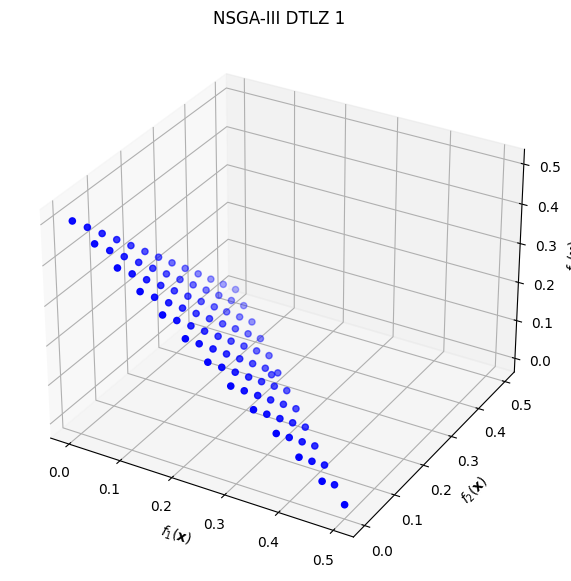

In [65]:
x = [point[0] for point in par]
y = [point[1] for point in par]
z = [point[2] for point in par]

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, color="blue")

plt.title("NSGA-III DTLZ 1")

ax.set_xlabel('$f_1(\mathbf{x})$')
ax.set_ylabel('$f_2(\mathbf{x})$')
ax.set_zlabel('$f_3(\mathbf{x})$')

plt.show()

In [66]:
NOBJ = 4
NDIM = 5
BOUND_LOW, BOUND_UP = 0.0, 1.0
NGEN = 500
CXPB = 0.8
MUTPB = 0.2

P = 7
H = factorial(NOBJ + P - 1) / (factorial(P) * factorial(NOBJ - 1))

MU = int(H + (4 - H % 4))

creator.create("FitnessMin", base.Fitness, weights=(-1.0,) * NOBJ) # for minimization
creator.create("Individual", list, fitness=creator.FitnessMin) 

toolbox = base.Toolbox()

toolbox.register("evaluate", dtlz2) #Fitness Function

#Chromosome representation Real Valued
toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, NDIM) 
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0)
toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/NDIM)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("select", tools.selNSGA2)

toolbox.pop_size = MU
toolbox.max_gen = NGEN
toolbox.mut_prob = MUTPB
toolbox.cross_prob = CXPB

# Initialize statistics object
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
stats.register("time", measure_time)

logbook = tools.Logbook()
logbook.header = "gen", "evals", "std", "min", "avg", "max", "time"

# stats = tools.Statistics()

C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [68]:
start_time = time.time()
res, logbook = nsga_ii(toolbox, seed=1, stats=stats, verbose=True)

fronts = tools.emo.sortLogNondominated(res, len(res))

for i, inds in enumerate(fronts):
    par = [toolbox.evaluate(ind) for ind in inds]
    df = pd.DataFrame(par)

df.to_csv('deap_fitness_nsga2_dtlz2_120_500_4_5.csv', index=False)

0.010970592498779297
gen	nevals	avg     	std    	min        	max   	time     
0  	124   	0.453575	0.36343	0.000293445	1.3874	0.0109706
0.08078432083129883
1  	124   	0.438809	0.329027	0.000293445	1.3874	0.0807843
0.17852091789245605
2  	124   	0.441302	0.316239	0.000293445	1.3874	0.178521 
0.2403557300567627
3  	124   	0.435951	0.316164	9.15325e-06	1.3874	0.240356 
0.3061814308166504
4  	124   	0.43305 	0.315596	9.15325e-06	1.3874	0.306181 
0.36663818359375
5  	124   	0.435305	0.302728	9.15325e-06	1.13006	0.366638 
0.4414405822753906
6  	124   	0.434538	0.301755	9.15325e-06	1.13006	0.441441 
0.4993245601654053
7  	124   	0.432522	0.30155 	9.14883e-06	1.13006	0.499325 
0.5641531944274902
8  	124   	0.42585 	0.309607	9.14883e-06	1.13231	0.564153 
0.63100266456604
9  	124   	0.419316	0.314246	3.39494e-06	1.13233	0.631003 
0.6908807754516602
10 	124   	0.417988	0.314876	3.39494e-06	1.1366 	0.690881 
0.7486896514892578
11 	124   	0.414716	0.312779	3.39494e-06	1.13006	0.74869  
0.81456708908

7.40073823928833
108	124   	0.411132	0.292464	9.37214e-11	1.0266 	7.40074  
7.474539756774902
109	124   	0.410502	0.294589	9.37214e-11	1.0319 	7.47454  
7.530391454696655
110	124   	0.407999	0.296857	9.37214e-11	1.0319 	7.53039  
7.590271472930908
111	124   	0.409794	0.294551	1.27764e-12	1.0319 	7.59027  
7.657095670700073
112	124   	0.410233	0.293231	1.27752e-12	1.0319 	7.6571   
7.74785304069519
113	124   	0.414164	0.288161	1.27752e-12	1.0319 	7.74785  
7.863296031951904
114	124   	0.409673	0.294688	1.27752e-12	1.0319 	7.8633   
7.959378719329834
115	124   	0.414281	0.289264	1.27752e-12	1.0319 	7.95938  
8.030187368392944
116	124   	0.40952 	0.295564	1.27752e-12	1.0319 	8.03019  
8.11496114730835
117	124   	0.414398	0.287935	1.27752e-12	1.0319 	8.11496  
8.195744037628174
118	124   	0.413035	0.291371	1.27752e-12	1.0319 	8.19574  
8.265557765960693
119	124   	0.409537	0.296075	1.27752e-12	1.03573	8.26556  
8.346342086791992
120	124   	0.414741	0.288087	1.27752e-12	1.03573	8.34634  
8.

15.615065097808838
214	124   	0.410192	0.287366	3.53779e-18	1.00872	15.6151  
15.680407762527466
215	124   	0.406925	0.292396	3.53779e-18	1.00872	15.6804  
15.760704040527344
216	124   	0.411843	0.285209	3.53779e-18	1.00793	15.7607  
15.81356167793274
217	124   	0.408755	0.28938 	3.53744e-18	1.00793	15.8136  
15.865487575531006
218	124   	0.412246	0.284372	3.53744e-18	1.00917	15.8655  
15.924333572387695
219	124   	0.410477	0.286748	3.53744e-18	1.00917	15.9243  
15.984131813049316
220	124   	0.407128	0.291626	3.53744e-18	1.00917	15.9841  
16.05294919013977
221	124   	0.406862	0.292115	3.53744e-18	1.00917	16.0529  
16.10983371734619
222	124   	0.407026	0.292199	3.53744e-18	1.00917	16.1098  
16.17300009727478
223	124   	0.407658	0.291119	3.53744e-18	1.00917	16.173   
16.239822387695312
224	124   	0.410371	0.287232	3.53744e-18	1.00926	16.2398  
16.298662662506104
225	124   	0.404176	0.296116	3.53744e-18	1.0096 	16.2987  
16.364527225494385
226	124   	0.406292	0.293296	3.53744e-18	1.0101 	

22.786961555480957
322	124   	0.409592	0.289621	3.3985e-21 	1.00446	22.787   
22.856775760650635
323	124   	0.411835	0.286594	3.3985e-21 	1.00446	22.8568  
22.918609380722046
324	124   	0.408355	0.291077	3.3985e-21 	1.00446	22.9186  
22.98941922187805
325	124   	0.406207	0.294161	3.3985e-21 	1.00446	22.9894  
23.099124908447266
326	124   	0.405576	0.29489 	3.3985e-21 	1.00446	23.0991  
23.16295599937439
327	124   	0.406056	0.294591	3.3985e-21 	1.00445	23.163   
23.22478985786438
328	124   	0.408368	0.290981	3.3985e-21 	1.00445	23.2248  
23.31155800819397
329	124   	0.40678 	0.293047	3.3985e-21 	1.00445	23.3116  
23.387355089187622
330	124   	0.406103	0.294053	3.3985e-21 	1.00443	23.3874  
23.490079164505005
331	124   	0.406256	0.293661	3.3985e-21 	1.00443	23.4901  
23.546926975250244
332	124   	0.407231	0.29215 	3.3985e-21 	1.00764	23.5469  
23.605081796646118
333	124   	0.405477	0.294701	3.3985e-21 	1.00764	23.6051  
23.673895120620728
334	124   	0.409911	0.288703	3.3985e-21 	1.00794	

30.00030827522278
429	124   	0.411287	0.287768	8.9576e-23 	1.03364	30.0003  
30.09206247329712
430	124   	0.408758	0.291475	8.9576e-23 	1.04151	30.0921  
30.165864944458008
431	124   	0.409592	0.290019	8.9576e-23 	1.04151	30.1659  
30.22370982170105
432	124   	0.413305	0.2862  	8.9576e-23 	1.04151	30.2237  
30.32543921470642
433	124   	0.411397	0.288401	8.9576e-23 	1.04151	30.3254  
30.38528084754944
434	124   	0.412241	0.288001	8.9576e-23 	1.04151	30.3853  
30.44549560546875
435	124   	0.407165	0.295022	8.9576e-23 	1.04151	30.4455  
30.50787591934204
436	124   	0.409312	0.292323	8.9576e-23 	1.04151	30.5079  
30.564687967300415
437	124   	0.411019	0.289188	8.9576e-23 	1.04151	30.5647  
30.639490365982056
438	124   	0.407055	0.294471	8.9576e-23 	1.04151	30.6395  
30.70332098007202
439	124   	0.402498	0.300783	8.9576e-23 	1.04151	30.7033  
30.764153003692627
440	124   	0.406376	0.295561	8.9576e-23 	1.04151	30.7642  
30.82834529876709
441	124   	0.41402 	0.284603	8.9576e-23 	1.04151	30.82

In [69]:
df = pd.DataFrame(logbook)
df.to_csv('deap_time_nsga2_dtlz2_120_500_4_5.csv', index=False)

In [70]:
df.columns = ['f1','f2','f3','f4']
sns.pairplot(df)
plt.show()

ValueError: Length mismatch: Expected axis has 7 elements, new values have 4 elements

In [71]:
NOBJ = 4
NDIM = 5
BOUND_LOW, BOUND_UP = 0.0, 1.0
NGEN = 500
CXPB = 0.8
MUTPB = 0.2

P = 7
H = factorial(NOBJ + P - 1) / (factorial(P) * factorial(NOBJ - 1))

MU = int(H + (4 - H % 4))

ref_points = tools.uniform_reference_points(NOBJ, P)

creator.create("FitnessMin", base.Fitness, weights=(-1.0,) * NOBJ) # for minimization
creator.create("Individual", list, fitness=creator.FitnessMin) 

toolbox = base.Toolbox()

toolbox.register("evaluate", dtlz2) #Fitness Function
toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, NDIM)

toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)

toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0)
toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/NDIM)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("select", tools.selNSGA3, ref_points=ref_points)

toolbox.pop_size = MU
toolbox.max_gen = NGEN
toolbox.mut_prob = MUTPB
toolbox.cross_prob = CXPB

# Initialize statistics object
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
stats.register("time", measure_time)

logbook = tools.Logbook()
logbook.header = "gen", "evals", "std", "min", "avg", "max", "time"

C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [74]:
start_time = time.time()
res, logbook = nsga_iii(toolbox,stats,logbook,NGEN,MU,CXPB,MUTPB,verbose=True)

fronts = tools.emo.sortLogNondominated(res, len(res))

for i, inds in enumerate(fronts):
    par = [toolbox.evaluate(ind) for ind in inds]
    df = pd.DataFrame(par)

df.to_csv('deap_fitness_nsga3_dtlz2_120_500_4_5.csv', index=False)

0.060357093811035156
gen	evals	std     	min        	avg     	max    	time     
1  	     	0.387903	0.000655216	0.449574	1.38669	0.0603571
0.07627654075622559
2  	     	0.363276	7.67376e-05	0.439849	1.38669	0.0762765
0.09322881698608398
3  	     	0.345415	1.44243e-06	0.442207	1.28449	0.0932288
0.10922598838806152
4  	     	0.343691	1.44243e-06	0.430481	1.28449	0.109226 
0.12817931175231934
5  	     	0.343298	1.44243e-06	0.41933 	1.28449	0.128179 
0.14509153366088867
6  	     	0.341492	1.44243e-06	0.412545	1.20363	0.145092 
0.1640455722808838
7  	     	0.346094	1.44243e-06	0.405629	1.25555	0.164046 
0.18698620796203613
8  	     	0.34634 	2.36539e-07	0.402468	1.25555	0.186986 
0.20693302154541016
9  	     	0.344288	4.2854e-06 	0.394973	1.25555	0.206933 
0.22687959671020508
10 	     	0.33939 	4.2854e-06 	0.392204	1.11826	0.22688  
0.2468252182006836
11 	     	0.339486	3.42308e-06	0.387748	1.11826	0.246825 
0.2657749652862549
12 	     	0.340661	3.42308e-06	0.387193	1.11826	0.265775 
0.293698

3.174070119857788
113	     	0.334956	1.29209e-06	0.371625	1.00739	3.17407  
3.210973024368286
114	     	0.333598	1.29209e-06	0.372809	1.00739	3.21097  
3.2379000186920166
115	     	0.335479	1.29209e-06	0.371105	1.00739	3.2379   
3.2668235301971436
116	     	0.334646	1.29209e-06	0.371862	1.00739	3.26682  
3.289759635925293
117	     	0.335201	1.29209e-06	0.371388	1.00739	3.28976  
3.320014715194702
118	     	0.333114	1.29209e-06	0.373238	1.00739	3.32001  
3.34395170211792
119	     	0.334849	9.29586e-07	0.371735	1.00739	3.34395  
3.372873306274414
120	     	0.333195	9.29586e-07	0.373183	1.00739	3.37287  
3.4037907123565674
121	     	0.334132	9.29586e-07	0.372345	1.00739	3.40379  
3.4379496574401855
122	     	0.332445	9.29586e-07	0.373889	1.00739	3.43795  
3.471858501434326
123	     	0.334353	9.29586e-07	0.372117	1.00739	3.47186  
3.506765365600586
124	     	0.332904	5.91571e-08	0.373518	1.00739	3.50677  
3.535689353942871
125	     	0.334893	5.91571e-08	0.371679	1.00739	3.53569  
3.5725884

6.411395311355591
221	     	0.334988	4.55977e-08	0.371232	1      	6.4114   
6.4393603801727295
222	     	0.333969	4.10245e-08	0.372162	1      	6.43936  
6.469242572784424
223	     	0.333462	4.10245e-08	0.3726  	1      	6.46924  
6.4902215003967285
224	     	0.333927	4.10245e-08	0.372177	1      	6.49022  
6.519107341766357
225	     	0.33314 	4.10245e-08	0.372878	1      	6.51911  
6.546035528182983
226	     	0.333678	4.10245e-08	0.372403	1      	6.54604  
6.572967052459717
227	     	0.334839	4.10245e-08	0.37135 	1      	6.57297  
6.601886034011841
228	     	0.333485	4.10245e-08	0.372566	1      	6.60189  
6.621832847595215
229	     	0.334352	4.10245e-08	0.371816	1      	6.62183  
6.653745889663696
230	     	0.333794	4.10245e-08	0.372289	1      	6.65375  
6.680189847946167
231	     	0.333396	4.10245e-08	0.372673	1      	6.68019  
6.704163312911987
232	     	0.332989	4.10245e-08	0.373009	1      	6.70416  
6.733048677444458
233	     	0.333095	1.09651e-09	0.372915	1.00009	6.73305  
6.75598835

9.182531118392944
331	     	0.334688	1.66275e-11	0.371666	1.00672	9.18253  
9.204469442367554
332	     	0.333925	1.66275e-11	0.372351	1.00672	9.20447  
9.223455905914307
333	     	0.334768	1.66275e-11	0.371593	1.00672	9.22346  
9.24236798286438
334	     	0.334081	1.66275e-11	0.37221 	1.00672	9.24237  
9.260826587677002
335	     	0.335095	1.66275e-11	0.371297	1.00672	9.26083  
9.280811071395874
336	     	0.331892	1.66275e-11	0.374163	1.00672	9.28081  
9.299762487411499
337	     	0.33393 	1.66275e-11	0.372346	1.00672	9.29976  
9.319735288619995
338	     	0.333161	1.66275e-11	0.372943	1.00672	9.31974  
9.338684558868408
339	     	0.333449	1.66275e-11	0.372686	1.00672	9.33868  
9.35856556892395
340	     	0.333372	1.66275e-11	0.372755	1.00672	9.35857  
9.381505489349365
341	     	0.334636	1.66275e-11	0.37162 	1.00672	9.38151  
9.401489973068237
342	     	0.335786	1.66275e-11	0.370581	1.00672	9.40149  
9.424427032470703
343	     	0.334008	1.66275e-11	0.372185	1.00672	9.42443  
9.444377183914

12.169145584106445
441	     	0.332783	1.60747e-16	0.373175	1      	12.1691  
12.194079637527466
442	     	0.334095	9.77165e-18	0.372001	1      	12.1941  
12.219011783599854
443	     	0.332935	9.77165e-18	0.373039	1      	12.219   
12.24195146560669
444	     	0.33277 	9.77165e-18	0.373186	1      	12.242   
12.266883611679077
445	     	0.334242	9.77165e-18	0.371869	1      	12.2669  
12.286830425262451
446	     	0.334023	9.77165e-18	0.372066	1      	12.2868  
12.307815313339233
447	     	0.333619	9.77165e-18	0.372464	1      	12.3078  
12.32971477508545
448	     	0.333454	9.77165e-18	0.372611	1      	12.3297  
12.348702192306519
449	     	0.332296	9.77165e-18	0.373606	1      	12.3487  
12.370606899261475
450	     	0.334883	9.77165e-18	0.371289	1      	12.3706  
12.39853024482727
451	     	0.333927	1.34209e-18	0.372149	1      	12.3985  
12.418476819992065
452	     	0.331718	1.34209e-18	0.374124	1      	12.4185  
12.440455913543701
453	     	0.333589	1.34209e-18	0.372454	1      	12.4405  
12

In [76]:
df = pd.DataFrame(logbook)
df.to_csv('deap_time_nsga3_dtlz2_120_500_4_5.csv', index=False)

In [77]:
NOBJ = 6
NDIM = 6
BOUND_LOW, BOUND_UP = 0.0, 1.0
NGEN = 500
CXPB = 0.8
MUTPB = 0.2

P = 7
# H = factorial(NOBJ + P - 1) / (factorial(P) * factorial(NOBJ - 1))

MU = 252

creator.create("FitnessMin", base.Fitness, weights=(-1.0,) * NOBJ) # for minimization
creator.create("Individual", list, fitness=creator.FitnessMin) 

toolbox = base.Toolbox()

toolbox.register("evaluate", dtlz3) #Fitness Function

#Chromosome representation Real Valued
toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, NDIM) 
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0)
toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/NDIM)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("select", tools.selNSGA2)

toolbox.pop_size = MU
toolbox.max_gen = NGEN
toolbox.mut_prob = MUTPB
toolbox.cross_prob = CXPB

# Initialize statistics object
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
stats.register("time", measure_time)

logbook = tools.Logbook()
logbook.header = "gen", "evals", "std", "min", "avg", "max", "time"

C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [78]:
start_time = time.time()
res, logbook = nsga_ii(toolbox, seed=1, stats=stats, verbose=True)

fronts = tools.emo.sortLogNondominated(res, len(res))

for i, inds in enumerate(fronts):
    par = [toolbox.evaluate(ind) for ind in inds]
    df = pd.DataFrame(par)

df.to_csv('deap_fitness_nsga2_dtlz3_120_500_6_6.csv', index=False)

0.014958381652832031
gen	nevals	avg    	std    	min        	max    	time     
0  	252   	29.5288	41.8529	7.75336e-05	207.183	0.0149584
0.5106339454650879
1  	252   	18.0999	37.8946	2.3636e-05 	207.183	0.510634 
0.8268418312072754
2  	252   	12.2416	32.6509	2.3636e-05 	210.748	0.826842 
1.2726495265960693
3  	252   	9.4563 	28.4374	2.56648e-07	207.004	1.27265  
1.5538959503173828
4  	252   	6.84813	21.9394	2.56648e-07	196.468	1.5539   
1.8247928619384766
5  	252   	4.4367 	15.3218	2.56648e-07	198.626	1.82479  
2.0841009616851807
6  	252   	2.74367	10.6523	2.56648e-07	133.495	2.0841   
2.622657299041748
7  	252   	2.60077	10.7525	1.55045e-08	133.495	2.62266  
3.0375478267669678
8  	252   	2.19597	9.42073	1.55045e-08	136.027	3.03755  
3.373647928237915
9  	252   	1.54594	6.26846	1.55045e-08	122.339	3.37365  
3.67982816696167
10 	252   	1.38986	6.36148	1.55045e-08	122.339	3.67983  
3.950192928314209
11 	252   	1.08944	4.95503	1.31687e-09	103.088	3.95019  
4.30859375
12 	252   	0.881111	3.0

32.483057737350464
107	252   	3.03237 	7.10929	7.70312e-20	47.8851	32.4831  
32.753334283828735
108	252   	3.10935 	7.42793	7.70312e-20	62.0093	32.7533  
32.99695944786072
109	252   	3.20919 	7.8892 	7.70312e-20	121.417	32.997   
33.26647710800171
110	252   	3.18799 	8.11571	7.70312e-20	121.417	33.2665  
33.53586411476135
111	252   	3.43588 	8.83498	7.70312e-20	121.417	33.5359  
33.75627541542053
112	252   	3.50056 	8.89586	7.70312e-20	121.417	33.7563  
33.98853325843811
113	252   	3.77023 	9.28081	7.70312e-20	103.088	33.9885  
34.24680137634277
114	252   	3.75096 	9.05463	7.70312e-20	87.3055	34.2468  
34.59686255455017
115	252   	3.69322 	8.83738	7.70312e-20	87.3055	34.5969  
34.882100343704224
116	252   	3.85709 	9.15073	7.70312e-20	87.3055	34.8821  
35.205522537231445
117	252   	4.17897 	10.2725	7.70312e-20	138.174	35.2055  
35.43428039550781
118	252   	4.42638 	11.1292	6.50877e-20	138.174	35.4343  
35.67340803146362
119	252   	4.55083 	11.6977	6.50877e-20	138.174	35.6734  
35.91010

64.08333897590637
215	252   	6.88496 	19.0122	1.29791e-26	188.017	64.0833  
64.37272453308105
216	252   	7.20158 	20.1693	1.29791e-26	188.017	64.3727  
64.64695429801941
217	252   	7.25946 	20.08  	6.1536e-27 	188.017	64.647   
65.00000834465027
218	252   	7.23479 	19.8999	6.1536e-27 	188.017	65       
65.33112382888794
219	252   	7.36152 	20.1749	6.1536e-27 	187.992	65.3311  
65.62034869194031
220	252   	7.3523  	20.2788	6.1536e-27 	187.992	65.6203  
65.8542742729187
221	252   	7.07463 	19.1987	6.1536e-27 	187.992	65.8543  
66.0986590385437
222	252   	7.3112  	19.6762	6.1536e-27 	197.207	66.0987  
66.43191480636597
223	252   	7.37375 	19.5685	6.1536e-27 	197.207	66.4319  
66.67725872993469
224	252   	7.46376 	19.1571	6.1536e-27 	197.207	66.6773  
66.94157314300537
225	252   	7.84347 	20.575 	7.67687e-29	197.207	66.9416  
67.19461107254028
226	252   	8.28414 	22.1028	7.67687e-29	197.207	67.1946  
67.4599027633667
227	252   	8.68119 	22.9994	7.67687e-29	199.616	67.4599  
67.716217756271

98.98612761497498
324	252   	18.5704 	44.6167	0          	212.743	98.9861  
99.34516787528992
325	252   	18.3908 	44.3269	0          	212.743	99.3452  
99.67532873153687
326	252   	18.8507 	44.8244	0          	212.743	99.6753  
100.00998282432556
327	252   	18.9206 	45.1577	0          	212.743	100.01   
100.45330691337585
328	252   	18.0604 	44.0309	0          	212.743	100.453  
100.79849123954773
329	252   	18.1755 	44.1565	0          	212.743	100.798  
101.1759603023529
330	252   	17.3556 	42.6826	0          	213    	101.176  
101.5590090751648
331	252   	17.36   	42.5099	0          	212.743	101.559  
101.94078230857849
332	252   	18.1145 	43.8597	0          	216.728	101.941  
102.31378865242004
333	252   	18.3046 	44.3222	0          	215.195	102.314  
102.71371245384216
334	252   	18.5674 	44.4435	0          	212.746	102.714  
103.05088543891907
335	252   	18.313  	44.4219	0          	212.794	103.051  
103.49161386489868
336	252   	17.7521 	43.5709	0          	213.202	103.492  
103.

132.4340488910675
431	252   	23.4769 	50.0337	0          	212.31 	132.434  
132.71052384376526
432	252   	23.3273 	49.9628	0          	212.31 	132.711  
132.98821449279785
433	252   	23.1461 	49.1778	0          	213.184	132.988  
133.3961215019226
434	252   	23.5387 	49.7187	0          	213.184	133.396  
133.68037915229797
435	252   	23.7151 	50.4185	0          	213.184	133.68   
133.92073965072632
436	252   	23.4916 	50.0663	0          	213.184	133.921  
134.31694650650024
437	252   	22.8926 	49.0503	0          	213.184	134.317  
134.59471559524536
438	252   	23.7858 	50.1177	0          	213.184	134.595  
135.0046169757843
439	252   	23.8524 	49.9779	0          	213.184	135.005  
135.24397706985474
440	252   	24.1315 	50.1606	0          	213.184	135.244  
135.52123475074768
441	252   	23.8993 	50.2533	0          	213.184	135.521  
135.75617027282715
442	252   	24.3339 	51.3398	0          	213.184	135.756  
135.97921586036682
443	252   	25.4477 	52.8876	0          	213.184	135.979  
13

In [80]:
df = pd.DataFrame(logbook)
df.to_csv('deap_time_nsga2_dtlz3_120_500_6_6.csv', index=False)

In [ ]:
df.columns = ['f1','f2','f3','f4','f5','f6']
sns.pairplot(df)
plt.show()

In [81]:
NOBJ = 6
NDIM = 6
BOUND_LOW, BOUND_UP = 0.0, 1.0
NGEN = 500
CXPB = 0.8
MUTPB = 0.2

P = 5
H = factorial(NOBJ + P - 1) / (factorial(P) * factorial(NOBJ - 1))

ref_points = tools.uniform_reference_points(NOBJ, P)

MU = ref_points.shape[0]

creator.create("FitnessMin", base.Fitness, weights=(-1.0,) * NOBJ) # for minimization
creator.create("Individual", list, fitness=creator.FitnessMin) 

toolbox = base.Toolbox()

toolbox.register("evaluate", dtlz3) #Fitness Function
toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, NDIM)

toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
# toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, NDIM)
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0)
toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/NDIM)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("select", tools.selNSGA3, ref_points=ref_points)

toolbox.pop_size = MU
toolbox.max_gen = NGEN
toolbox.mut_prob = MUTPB
toolbox.cross_prob = CXPB

# Initialize statistics object
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
stats.register("time", measure_time)

logbook = tools.Logbook()
logbook.header = "gen", "evals", "std", "min", "avg", "max", "time"

C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [82]:
start_time = time.time()
res, logbook = nsga_iii(toolbox=toolbox,stats=stats,logbook=logbook,NGEN=NGEN,MU=MU,CXPB=CXPB,MUTPB=MUTPB,verbose=True)

fronts = tools.emo.sortLogNondominated(res, len(res))

for i, inds in enumerate(fronts):
    par = [toolbox.evaluate(ind) for ind in inds]
    df = pd.DataFrame(par)

df.to_csv('deap_fitness_nsga3_dtlz3_252_500_6_6.csv', index=False)

0.06885194778442383
gen	evals	std   	min       	avg    	max    	time     
1  	     	43.938	8.7518e-05	30.9659	218.657	0.0688519
0.17101597785949707
2  	     	34.7589	8.7518e-05	17.2229	220.074	0.171016 
0.25778651237487793
3  	     	27.2023	5.1463e-06	10.4445	216.147	0.257787 
0.3445148468017578
4  	     	25.1164	5.1463e-06	8.51708	201.198	0.344515 
0.4392991065979004
5  	     	25.4134	1.13337e-06	7.61044	201.198	0.439299 
0.5150594711303711
6  	     	21.3267	1.65444e-08	5.08279	190.528	0.515059 
0.5938467979431152
7  	     	14.9816	1.65444e-08	2.8579 	184.862	0.593847 
0.6586353778839111
8  	     	4.78524	1.65444e-08	1.06035	90.1719	0.658635 
0.7394161224365234
9  	     	1.81074	2.00274e-09	0.600496	28.2307	0.739416 
0.7952685356140137
10 	     	1.81454	2.00274e-09	0.564212	28.2307	0.795269 
0.8630859851837158
11 	     	1.60933	2.00274e-09	0.502376	28.2307	0.863086 
0.9273133277893066
12 	     	0.915876	3.97991e-09	0.391485	15.7017	0.927313 
1.011091947555542
13 	     	0.779734	5.9304

10.436603784561157
109	     	0.307968	1.46995e-07	0.269338	1.00626	10.4366  
10.54032588005066
110	     	0.30912 	5.87489e-07	0.270905	1.70566	10.5403  
10.650032758712769
111	     	0.309682	3.94618e-07	0.27044 	1.70566	10.65    
10.795643091201782
112	     	0.308133	3.94618e-07	0.271948	1.70588	10.7956  
10.916320085525513
113	     	0.312354	5.87489e-07	0.270035	1.80296	10.9163  
11.036000490188599
114	     	0.311473	5.87489e-07	0.270793	1.80296	11.036   
11.148697853088379
115	     	0.311985	1.38613e-06	0.270237	1.80296	11.1487  
11.261106729507446
116	     	0.310835	1.38613e-06	0.271515	1.77354	11.2611  
11.376793384552002
117	     	0.308631	1.38613e-06	0.268736	1.00626	11.3768  
11.465555906295776
118	     	0.309021	1.38613e-06	0.268082	1.00626	11.4656  
11.556312561035156
119	     	0.308673	1.89753e-06	0.268354	1.00626	11.5563  
11.646552801132202
120	     	0.307391	9.04631e-08	0.269765	1.00626	11.6466  
11.74030351638794
121	     	0.306484	9.04631e-08	0.270807	1.00626	11.7403  
1

21.290705919265747
218	     	0.307553	8.0213e-07 	0.269034	1.00065	21.2907  
21.374524354934692
219	     	0.308261	8.0213e-07 	0.268222	1.00065	21.3745  
21.463242769241333
220	     	0.308409	8.0213e-07 	0.268018	1.00065	21.4632  
21.558027267456055
221	     	0.30753 	8.0213e-07 	0.26904 	1.00065	21.558   
21.645155668258667
222	     	0.307655	8.0213e-07 	0.268896	1.00065	21.6452  
21.73694658279419
223	     	0.307339	8.0213e-07 	0.269097	1.00065	21.7369  
21.847612619400024
224	     	0.307057	8.0213e-07 	0.269432	1.00065	21.8476  
21.939366579055786
225	     	0.306716	8.0213e-07 	0.269778	1.00065	21.9394  
22.03215718269348
226	     	0.307126	8.0213e-07 	0.269296	1.00065	22.0322  
22.12590527534485
227	     	0.307346	8.50168e-07	0.269059	1.00065	22.1259  
22.214629650115967
228	     	0.307252	8.50168e-07	0.269156	1.00065	22.2146  
22.299407482147217
229	     	0.307236	3.37649e-07	0.269153	1.00065	22.2994  
22.407554388046265
230	     	0.307825	3.37649e-07	0.268493	1.00065	22.4076  
22

32.533902168273926
326	     	0.308641	1.43738e-09	0.267281	1.0001 	32.5339  
32.6256959438324
327	     	0.308715	1.43738e-09	0.267196	1.0001 	32.6257  
32.713467836380005
328	     	0.308754	1.43738e-09	0.267151	1.0001 	32.7135  
32.813201904296875
329	     	0.308753	1.43738e-09	0.267152	1.0001 	32.8132  
32.90748333930969
330	     	0.308834	1.43738e-09	0.26706 	1.0001 	32.9075  
32.98881387710571
331	     	0.308825	1.43738e-09	0.26707 	1.0001 	32.9888  
33.10051608085632
332	     	0.308815	1.43738e-09	0.267081	1.0001 	33.1005  
33.20124530792236
333	     	0.308835	7.12246e-10	0.267055	1.0001 	33.2012  
33.28598237037659
334	     	0.308862	7.12246e-10	0.267023	1.0001 	33.286   
33.37179160118103
335	     	0.308962	7.12246e-10	0.266905	1.0001 	33.3718  
33.46749711036682
336	     	0.309031	7.12246e-10	0.266825	1.0001 	33.4675  
33.5562961101532
337	     	0.309074	7.12246e-10	0.266775	1.0001 	33.5563  
33.65300226211548
338	     	0.3091  	7.92069e-10	0.266743	1.0001 	33.653   
33.74977731

44.12661671638489
435	     	0.303439	7.17038e-09	0.273133	1.00007	44.1266  
44.238661766052246
436	     	0.300553	7.17038e-09	0.276306	1.00007	44.2387  
44.35287141799927
437	     	0.304275	5.07489e-08	0.2722  	1.00007	44.3529  
44.45858645439148
438	     	0.304022	5.07489e-08	0.272482	1.00007	44.4586  
44.546391010284424
439	     	0.303523	5.07489e-08	0.273038	1.00007	44.5464  
44.64612317085266
440	     	0.304438	5.07489e-08	0.27202 	1.00007	44.6461  
44.752798557281494
441	     	0.304669	5.07489e-08	0.271763	1.00007	44.7528  
44.850579261779785
442	     	0.305256	5.07489e-08	0.271107	1.00007	44.8506  
44.948275566101074
443	     	0.306333	5.07489e-08	0.269887	1.00007	44.9483  
45.03652572631836
444	     	0.306552	5.07489e-08	0.269639	1.00007	45.0365  
45.13725757598877
445	     	0.306627	5.07489e-08	0.26955 	1.00007	45.1373  
45.23100447654724
446	     	0.306436	5.07489e-08	0.269767	1.00007	45.231   
45.32327127456665
447	     	0.306499	5.07489e-08	0.269697	1.00007	45.3233  
45.4180

In [84]:
df = pd.DataFrame(logbook)
df.to_csv('deap_time_nsga3_dtlz3_252_500_6_6.csv', index=False)

In [23]:
NOBJ = 3
NDIM = 10
BOUND_LOW, BOUND_UP = 0.0, 1.0
NGEN = 500
CXPB = 0.8
MUTPB = 0.2

P = 12
H = factorial(NOBJ + P - 1) / (factorial(P) * factorial(NOBJ - 1))

ref_points = tools.uniform_reference_points(NOBJ, P)

MU = ref_points.shape[0]

creator.create("FitnessMin", base.Fitness, weights=(-1.0,) * NOBJ) # for minimization
creator.create("Individual", list, fitness=creator.FitnessMin) 

toolbox = base.Toolbox()

toolbox.register("evaluate", dtlz7) #Fitness Function

#Chromosome representation Real Valued
toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, NDIM) 
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0)
toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/NDIM)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("select", tools.selNSGA2)

toolbox.pop_size = MU
toolbox.max_gen = NGEN
toolbox.mut_prob = MUTPB
toolbox.cross_prob = CXPB

# Initialize statistics object
stats = tools.Statistics(lambda ind: ind.fitness.values)
# stats.register("avg", np.mean)
# stats.register("std", np.std)
# stats.register("min", np.min)
# stats.register("max", np.max)
stats.register("time", measure_time)

logbook = tools.Logbook()
# logbook.header = "gen", "evals", "std", "min", "avg", "max", "time"
logbook.header = "gen", "evals", "time"

C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [24]:
start_time = time.time()
res, logbook = nsga_ii(toolbox=toolbox, seed=32, stats=stats, verbose=False)

# fronts = tools.emo.sortLogNondominated(res, len(res))

# for i, inds in enumerate(fronts):
#     par = [toolbox.evaluate(ind) for ind in inds]
#     df = pd.DataFrame(par)

# df.to_csv('deap_fitness_nsga2_dtlz7_92_500_3_10.csv', index=False)

In [19]:
df = pd.DataFrame(logbook)
df.to_csv('deap_time_nsga2_dtlz7_92_500_3_10.csv', index=False)

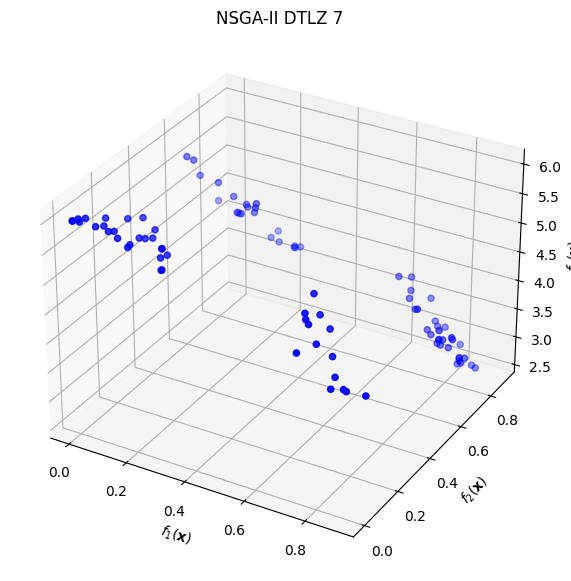

In [22]:
x = [point[0] for point in par]
y = [point[1] for point in par]
z = [point[2] for point in par]

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, color="blue")

plt.title("NSGA-II DTLZ 7")

ax.set_xlabel('$f_1(\mathbf{x})$')
ax.set_ylabel('$f_2(\mathbf{x})$')
ax.set_zlabel('$f_3(\mathbf{x})$')

plt.show()

In [14]:
NOBJ = 3
NDIM = 10
BOUND_LOW, BOUND_UP = 0.0, 1.0
NGEN = 500
CXPB = 0.8
MUTPB = 0.2

P = 12
H = factorial(NOBJ + P - 1) / (factorial(P) * factorial(NOBJ - 1))

ref_points = tools.uniform_reference_points(NOBJ, P)

MU = ref_points.shape[0]

creator.create("FitnessMin", base.Fitness, weights=(-1.0,) * NOBJ) # for minimization
creator.create("Individual", list, fitness=creator.FitnessMin) 

toolbox = base.Toolbox()

toolbox.register("evaluate", dtlz7) #Fitness Function
toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, NDIM)

toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
# toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, NDIM)
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0)
toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/NDIM)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("select", tools.selNSGA3, ref_points=ref_points)

toolbox.pop_size = MU
toolbox.max_gen = NGEN
toolbox.mut_prob = MUTPB
toolbox.cross_prob = CXPB

# Initialize statistics object
stats = tools.Statistics(lambda ind: ind.fitness.values)
# stats.register("avg", np.mean)
# stats.register("std", np.std)
# stats.register("min", np.min)
# stats.register("max", np.max)
stats.register("time", measure_time)

logbook = tools.Logbook()
# logbook.header = "gen", "evals", "std", "min", "avg", "max", "time"
logbook.header = "gen", "evals", "time"

C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\Maria\miniconda3\envs\fs\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [15]:
start_time = time.time()
res, logbook = nsga_iii(toolbox=toolbox,stats=stats,logbook=logbook,NGEN=NGEN,MU=MU,CXPB=CXPB,MUTPB=MUTPB,verbose=True)

fronts = tools.emo.sortLogNondominated(res, len(res))

for i, inds in enumerate(fronts):
    par = [toolbox.evaluate(ind) for ind in inds]
    df = pd.DataFrame(par)

df.to_csv('deap_fitness_nsga3_dtlz7_92_500_3_10.csv', index=False)

0.08422183990478516
gen	evals	time     
1  	     	0.0842218
0.10498285293579102
2  	     	0.104983 
0.16105914115905762
3  	     	0.161059 
0.17302584648132324
4  	     	0.173026 
0.18702316284179688
5  	     	0.187023 
0.20140433311462402
6  	     	0.201404 
0.21230673789978027
7  	     	0.212307 
0.23192358016967773
8  	     	0.231924 
0.25008535385131836
9  	     	0.250085 
0.2668468952178955
10 	     	0.266847 
0.28181028366088867
11 	     	0.28181  
0.29502439498901367
12 	     	0.295024 
0.31190037727355957
13 	     	0.3119   
0.32187318801879883
14 	     	0.321873 
0.336169958114624
15 	     	0.33617  
0.34902071952819824
16 	     	0.349021 
0.3619840145111084
17 	     	0.361984 
0.3730151653289795
18 	     	0.373015 
0.3849978446960449
19 	     	0.384998 
0.3990297317504883
20 	     	0.39903  
0.4110221862792969
21 	     	0.411022 
0.42398667335510254
22 	     	0.423987 
0.43888092041015625
23 	     	0.438881 
0.4568343162536621
24 	     	0.456834 
0.47188520431518555
25 	     

3.720083475112915
213	     	3.72008  
3.769324541091919
214	     	3.76932  
3.780243158340454
215	     	3.78024  
3.7989399433135986
216	     	3.79894  
3.8140363693237305
217	     	3.81404  
3.8309946060180664
218	     	3.83099  
3.8490848541259766
219	     	3.84908  
3.865997314453125
220	     	3.866    
3.879995346069336
221	     	3.88     
3.8959786891937256
222	     	3.89598  
3.913893938064575
223	     	3.91389  
3.9288899898529053
224	     	3.92889  
3.947807550430298
225	     	3.94781  
3.962364912033081
226	     	3.96236  
3.976426362991333
227	     	3.97643  
3.9943435192108154
228	     	3.99434  
4.01048731803894
229	     	4.01049  
4.022339105606079
230	     	4.02234  
4.041439533233643
231	     	4.04144  
4.056839466094971
232	     	4.05684  
4.073761463165283
233	     	4.07376  
4.103976488113403
234	     	4.10398  
4.134844541549683
235	     	4.13484  
4.1654064655303955
236	     	4.16541  
4.204340696334839
237	     	4.20434  
4.235909938812256
238	     	4.23591  
4.254

7.61519193649292
440	     	7.61519  
7.6275317668914795
441	     	7.62753  
7.641188621520996
442	     	7.64119  
7.656335115432739
443	     	7.65634  
7.675396203994751
444	     	7.6754   
7.690515756607056
445	     	7.69052  
7.707498550415039
446	     	7.7075   
7.7211995124816895
447	     	7.7212   
7.737506866455078
448	     	7.73751  
7.755218267440796
449	     	7.75522  
7.771385908126831
450	     	7.77139  
7.786125183105469
451	     	7.78613  
7.811530351638794
452	     	7.81153  
7.850293397903442
453	     	7.85029  
7.880174875259399
454	     	7.88017  
7.920271635055542
455	     	7.92027  
7.9664623737335205
456	     	7.96646  
7.997223615646362
457	     	7.99722  
8.01398515701294
458	     	8.01399  
8.031199932098389
459	     	8.0312   
8.053290367126465
460	     	8.05329  
8.076305389404297
461	     	8.07631  
8.09736156463623
462	     	8.09736  
8.116344690322876
463	     	8.11634  
8.135488510131836
464	     	8.13549  
8.152288913726807
465	     	8.15229  
8.1735517978

In [16]:
df = pd.DataFrame(logbook)
df.to_csv('deap_time_nsga3_dtlz7_92_500_3_10.csv', index=False)